In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

# Import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px

import os # used for navigating to image path
import imageio # used for writing images

from PIL import Image
from PIL import ImageFile

import datetime

import tensorflow as tf

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from skimage import io

import collections

##not sure why I need this but I do
ImageFile.LOAD_TRUNCATED_IMAGES = True

pd.set_option('max_colwidth', 300)

In [3]:
#importing test data, test dataframe with labels and column names

directory = '/Users/ilya/Desktop/Computer-Science/U-Capstone/raw_data'

test_images = np.load(os.path.join(directory,'test_images.npy'))
test_labels = np.load(os.path.join(directory, 'test_labels.npy'))

test_df = pd.read_csv(os.path.join(directory, 'test_df.csv'))
test_column_names = pd.read_csv(os.path.join(directory, 'test_column_names.csv'))

print("Done!")

Done!


In [4]:
#importing a pickled CNN model

model = tf.keras.models.load_model('/Users/ilya/Desktop/Computer-Science/U-Capstone/breeds_trained_model.h5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
model.evaluate(test_images, test_labels)

71/71 [==============================] - 748s 11s/step - loss: 4.1558 - accuracy: 0.4036


[4.155766487121582, 0.4035634696483612]

In [5]:
### We could not implement prediction on local with a full range of images, hence we opted  out to take a subset of the first 300 images
### Given that we shuffled the original dataframe in the pre-processing, this should not be an issue.

y_probs = model.predict(test_images[0:300])
label_df = test_df.drop(columns = ['Unnamed: 0'])

label_df = label_df.head(300)

column_labels = test_column_names.drop(columns = ['Unnamed: 0']).columns.to_list()

pred_labels_df = pd.DataFrame(y_probs, columns = column_labels).round(5)

label_df['pred_label'] = pred_labels_df.idxmax(axis = 1)

label_df

,file_path,image_id,breed_label,pred_label
0,/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/n02085782-Japanese_spaniel/n02085782_2914.jpg,n02085782_2914.jpg,Japanese_spaniel,Great_Pyrenees
1,/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/n02093859-Kerry_blue_terrier/n02093859_2579.jpg,n02093859_2579.jpg,Kerry_blue_terrier,Kerry_blue_terrier
2,/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/n02110806-basenji/n02110806_1688.jpg,n02110806_1688.jpg,basenji,Siberian_husky
3,/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/n02093991-Irish_terrier/n02093991_2322.jpg,n02093991_2322.jpg,Irish_terrier,Lakeland_terrier
4,/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/n02091134-whippet/n02091134_16420.jpg,n02091134_16420.jpg,whippet,Saluki
...,...,...,...,...
295,/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/n02091244-Ibizan_hound/n02091244_1120.jpg,n02091244_1120.jpg,Ibizan_hound,Ibizan_hound
296,/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/n02094433-Yorkshire_terrier/n02094433_5176.jpg,n02094433_5176.jpg,Yorkshire_terrier,Norwegian_elkhound
297,/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/n02093991-Irish_terrier/n02093991_4396.jpg,n02093991_4396.jpg,Irish_terrier,Irish_terrier
298,/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/n02093428-American_Staffordshire_terrier/n02093428_5326.jpg,n02093428_5326.jpg,American_Staffordshire_terrier,Italian_greyhound


In [6]:
## accuracy of the model on the subset of images

test_accuracy = round(len(label_df[label_df['breed_label'] == label_df['pred_label']])/len(label_df),4)
print("Accuracy on the test subset is: {}".format(test_accuracy))

Accuracy on the test subset is: 0.3833


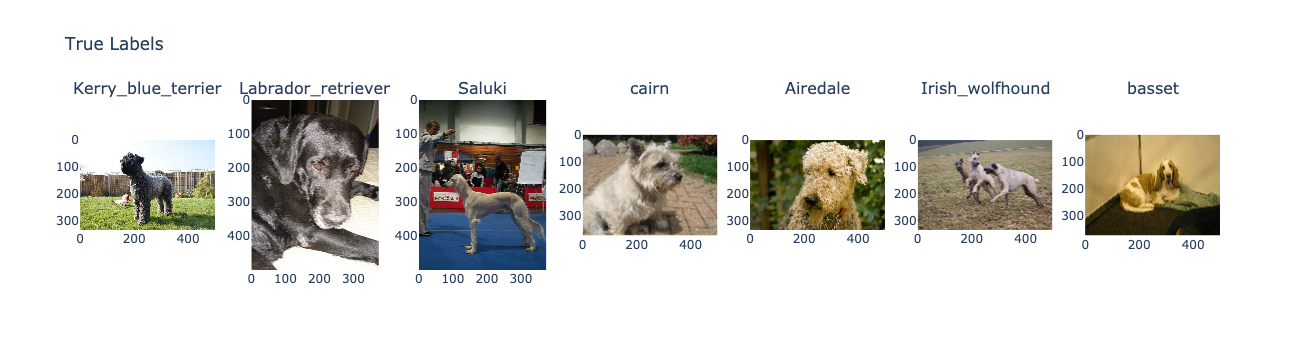

In [8]:
top_true_labels = label_df[label_df['breed_label'] == label_df['pred_label']].head(7)
tuple_of_true_labels = tuple(top_true_labels['pred_label'].to_list())

fig = make_subplots(rows=1, cols=7, subplot_titles=tuple_of_true_labels)

for file_path, i in zip(top_true_labels['file_path'], range(1, len(tuple_of_true_labels)+1)):
    
    img = io.imread(file_path)
    
    fig.add_trace(go.Image(z=img), 1, i)

fig.update_layout(height = 350, width = 1300, title_text = 'True Labels')
fig.show("png", height = 350, width = 1300)

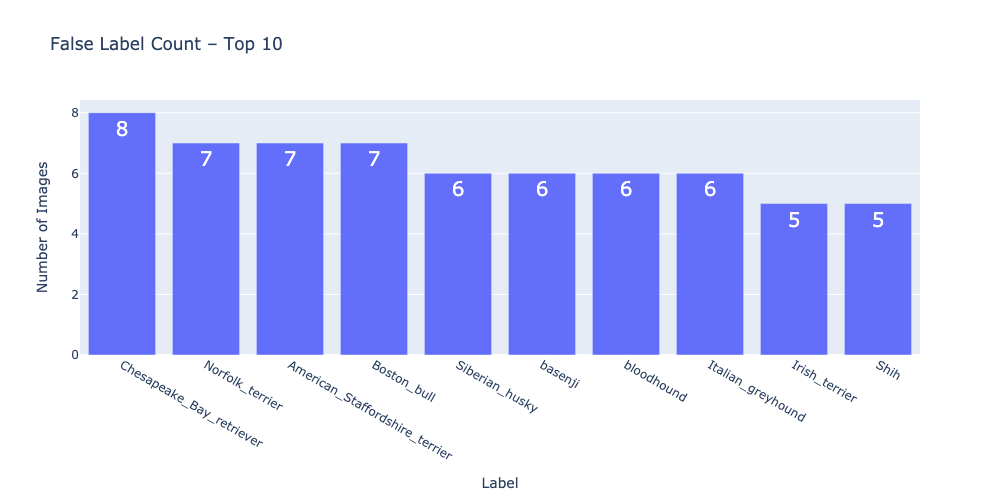

In [29]:
import plotly.graph_objects as go

# observing the most common issues – letter V, G and C seem to be the most problematic for the model to understand

false_label_count_df = label_df[label_df['breed_label'] != label_df['pred_label']].groupby('breed_label').count().reset_index()
false_label_count_df = false_label_count_df[['breed_label','file_path']].rename(columns = {'file_path':'image_count'}).\
                        sort_values(by = 'image_count', ascending = False).head(10)

false_label_count_df

fig = go.Figure([go.Bar(x=false_label_count_df['breed_label'],
                        y=false_label_count_df['image_count'],
                        text = false_label_count_df['image_count'])])

fig.update_traces(textposition='inside', textfont_size=20, texttemplate='%{text}')

fig.update_layout(title_text = 'False Label Count – Top 10',
                  yaxis_title = 'Number of Images',
                  xaxis_title = 'Label')

fig.show("png", height = 500, width = 1000)

In [7]:
def img_to_np_array(path):
    image = Image.open(path)
    image = image.resize((224,224))
    image = np.array(image)
    return image

In [8]:
def identify_dog_top_5(path):
    dog = img_to_np_array(path)
    dog_probs = model.predict(dog.reshape(1,224,224,3))
    prediction_list = list(dog_probs[0])
    label_list = test_column_names.drop(columns = ['Unnamed: 0']).columns.to_list()

    predict_dict = {}

    for a, b in zip(label_list, prediction_list):
        predict_dict[a] = b
        
    sorted_dict = {k: v for k, v in sorted(predict_dict.items(),
                                       key=lambda item: item[1],
                                       reverse = True)}

    top_5 = collections.Counter(sorted_dict).most_common(5)

    return top_5

In [9]:
def itentify_and_display(path):
    breed_prediction = identify_dog_top_5(path)[0][0]
    breed_certainty = identify_dog_top_5(path)[0][1]

    ## Load the image
    data = plt.imread(path)

    # Display the image
    plt.title("This is a {}! We are {}% certain about that.".format(breed_prediction, round(breed_certainty*100,1)))
    plt.imshow(data)
    plt.show()

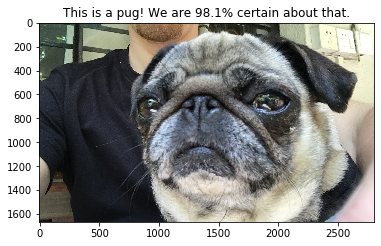

In [10]:
## example of a good prediction
itentify_and_display('/Users/ilya/Desktop/Computer-Science/U-Capstone/test/dumpling2.jpg')

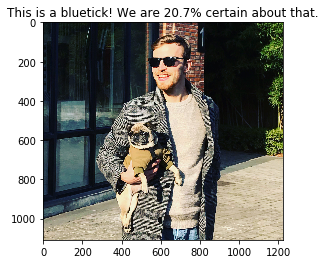

In [11]:
#example of a bad prediction

itentify_and_display('/Users/ilya/Desktop/Computer-Science/U-Capstone/test/dumpling4.jpg')